In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.14.0'

In [3]:
# Part A - Q1 A - Import and read ‘images.npy’.

file_path = 'images.npy'
# Load the array from the file
data = np.load(file_path,allow_pickle=True)

In [4]:
# Part1.1b-Split the data into Features(X) & labels(Y). Unify shape of all the images

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [5]:
print('X: ', X.shape)
print('mask: ', masks.shape)


X:  (409, 224, 224, 3)
mask:  (409, 224, 224)


In [6]:
# Part1.1c -Split the data into train and test[400:9]
X_test = X[400:]
y_test = masks[400:]
X_train = X[:400]
y_train = masks[:400]

print("X_train",X_train.shape)
print("y_train",y_train.shape)

print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (400, 224, 224, 3)
y_train (400, 224, 224)
X_test (9, 224, 224, 3)
y_test (9, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


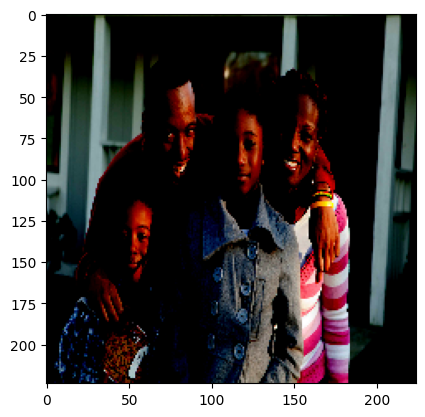

In [7]:
# Part A - Q1 D - Select random image from the train data and display original image and masked image.
pyplot.imshow(X[51])

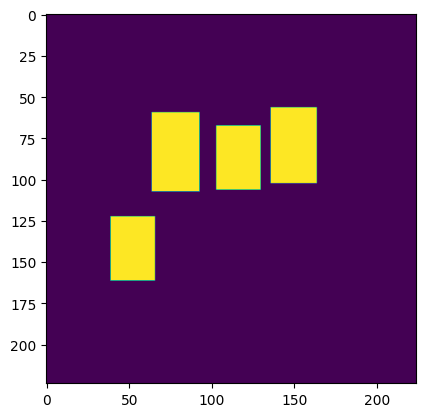

In [8]:
plt.imshow(masks[51])

In [17]:
# Part1.2a-Design a face mask detection model.
def model_new(trainable = True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    model = MobileNet(input_shape = IMG_SHAPE, alpha = 1, include_top = False, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer('conv_pw_1_relu').output
    block1 = model.get_layer('conv_pw_3_relu').output
    block2 = model.get_layer('conv_pw_5_relu').output
    block3 = model.get_layer('conv_pw_11_relu').output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = "sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs = model.input, outputs = x)


In [19]:
model = model_new(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

In [20]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

# Part1.2b-Design your own Dice Coefficient and Loss function.
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [21]:

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=3, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.1, patience=3, min_lr=1e-4, verbose=1, mode="min")

In [23]:
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [24]:

model.fit(X_train, y_train, validation_split=.1, epochs=1, batch_size=32, verbose=1)

12/12 [==============================] - 45s 3s/step - loss: 2.1815 - dice_coefficient: 0.1943 - val_loss: 2.2417 - val_dice_coefficient: 0.1796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


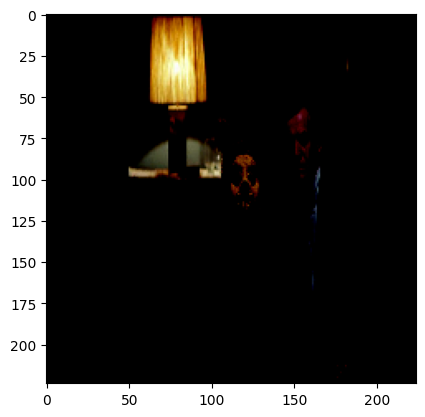

In [25]:
n = 1
sample_image = X_test[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

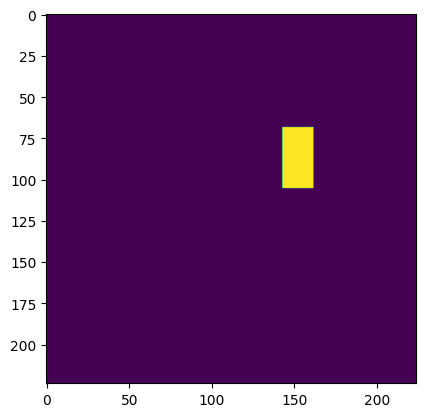

In [26]:
n = 1
sample_mask = y_test[n]
final_mask = sample_mask
plt.imshow(sample_mask)

1/1 [==============================] - 0s 406ms/step


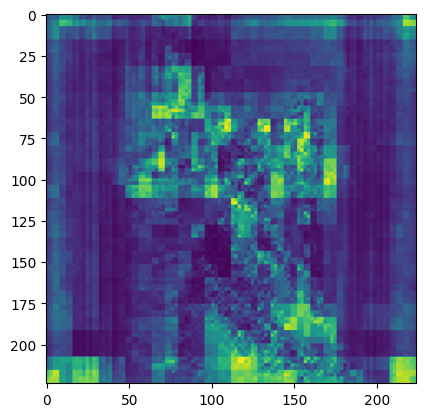

In [27]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


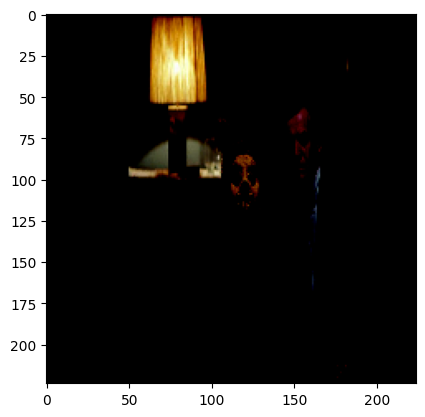

In [28]:
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


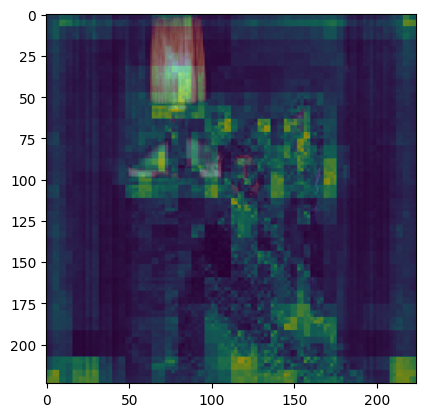

In [29]:
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of image:  (224, 224, 3)


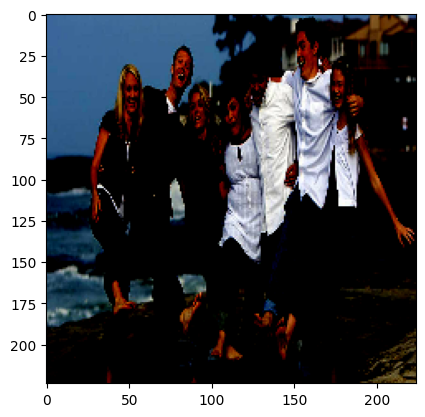

In [30]:
n = 2
sample_image = X_test[n]
final_image = sample_image
print('Shape of image: ', sample_image.shape)
plt.imshow(sample_image)

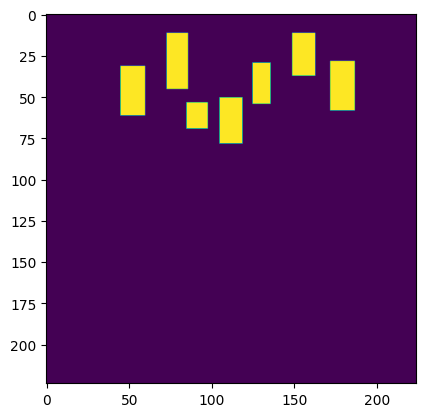

In [31]:
n = 2
sample_mask = y_test[n]
final_mask = sample_mask
plt.imshow(sample_mask)

1/1 [==============================] - 0s 85ms/step


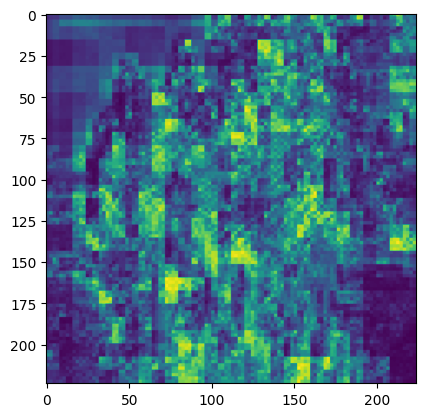

In [32]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


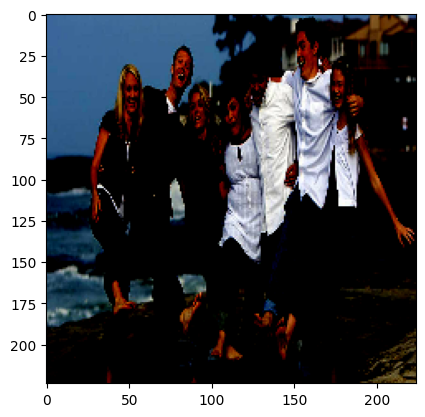

In [33]:
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


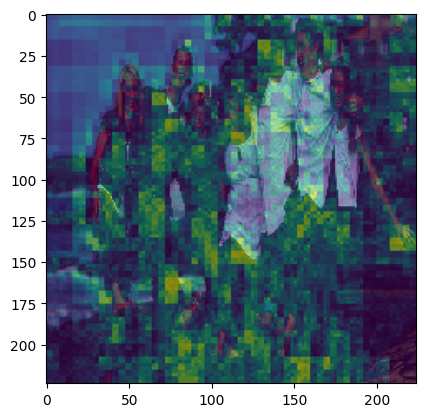

In [34]:
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()